In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [150]:
import gym
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
from gym import wrappers
import random
import numpy as np
import math
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [195]:
class Agent(gym.Env):

  def __init__(self):
    self.env = gym.make('CartPole-v0')
    self.env.seed(42)
    self.num_states = self.env.observation_space.shape[0]
    self.num_actions = self.env.action_space.n
    self.gamma = 0.99
    self.episodes = 1500
    self.timesteps = 0
    self.alpha = np.finfo(np.float32).eps.item()
    self.reward_per_episode = []
    self.avg_rewards = []
    self.steps_per_episode = []
    self.rewards = []
    self.past_probs = []
    # self.actor_model = self.create_model()
    # self.optimizer = keras.optimizers.Adam(learning_rate=0.01)
    # self.model._make_predict_function()

  def reset_all(self):
    self.rewards = []
    self.past_probs = []
    return self.env.reset()

  def create_model(self):
    print("Creating new model")
    inputs = layers.Input(shape=(4,))
    middle = layers.Dense(128, activation="relu")(inputs)
    actor = layers.Dense(2, activation="softmax")(middle)
    model = keras.Model(inputs=inputs, outputs=actor)
    return model

  def choose_action(self, state, actor_model):
    probability_dist = actor_model(state)
    action = np.random.choice(self.num_actions,p=np.squeeze(probability_dist))
    return probability_dist, action

  def calc_rewards(self):
    self.rewards = np.vstack(self.rewards)
    i = len(self.rewards) - 1
    sum = 0
    disc_rewards = [x*0 for x in range(len(self.rewards))]
    while i >= 0:
      sum = sum * self.gamma + self.rewards[i]
      disc_rewards[i] = sum
      i -= 1
    mu = np.mean(disc_rewards)
    sigma = np.std(disc_rewards)
    disc_rewards -= mu
    disc_rewards /= (sigma + self.alpha)

    return disc_rewards.tolist()

  # def train(self, tape):
    

  def execute(self):
    actor_model = self.create_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    for episode in range(self.episodes):
      old_state = self.reset_all()
      total_reward = 0
      t = 0
      done = False
      
      with tf.GradientTape() as tape:
        while not done:
          old_state = tf.convert_to_tensor(old_state)
          old_state = tf.expand_dims(old_state, 0)

          aprob, action = self.choose_action(old_state, actor_model)

          self.past_probs.append(tf.math.log(aprob[0, action]))
          next_state, reward, done, info = self.env.step(action)
          total_reward += reward
          if done and total_reward < 190:
            reward = -100
          self.rewards.append(reward)
          old_state = next_state
          t += 1
          self.timesteps += 1
          # print("timestep:",t,"reward: ",reward)
        
        disc_rewards = self.calc_rewards()
        losses = 0
        for i in range(len(self.rewards)):
          losses=losses + (-self.past_probs[i] * disc_rewards[i])
          # print(losses)
        # print("*************",actor_model.trainable_variables)
        grads = tape.gradient(losses, actor_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, actor_model.trainable_variables))

      self.reward_per_episode.append(total_reward)
      print("Episode: ",episode," Total Reward: ", total_reward
        ," Timesteps till now: ", self.timesteps)


In [196]:
agent = Agent()
agent.execute()

Creating new model
Episode:  0  Total Reward:  10.0  Timesteps till now:  10
Episode:  1  Total Reward:  22.0  Timesteps till now:  32
Episode:  2  Total Reward:  10.0  Timesteps till now:  42
Episode:  3  Total Reward:  35.0  Timesteps till now:  77
Episode:  4  Total Reward:  23.0  Timesteps till now:  100
Episode:  5  Total Reward:  19.0  Timesteps till now:  119
Episode:  6  Total Reward:  46.0  Timesteps till now:  165
Episode:  7  Total Reward:  24.0  Timesteps till now:  189
Episode:  8  Total Reward:  29.0  Timesteps till now:  218
Episode:  9  Total Reward:  18.0  Timesteps till now:  236
Episode:  10  Total Reward:  47.0  Timesteps till now:  283
Episode:  11  Total Reward:  24.0  Timesteps till now:  307
Episode:  12  Total Reward:  16.0  Timesteps till now:  323
Episode:  13  Total Reward:  28.0  Timesteps till now:  351
Episode:  14  Total Reward:  53.0  Timesteps till now:  404
Episode:  15  Total Reward:  53.0  Timesteps till now:  457
Episode:  16  Total Reward:  28.0  

Plotting analysis....
Rewards vs episodes


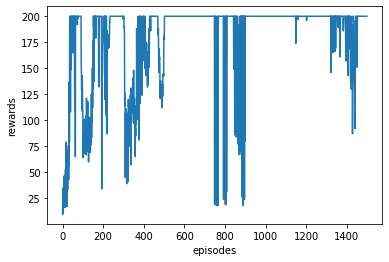

Average Rewards vs episodes


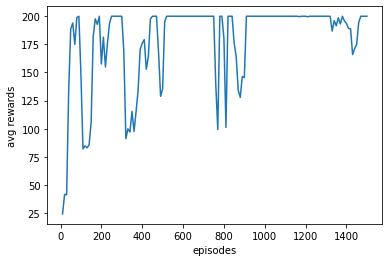

In [197]:
print("Plotting analysis....")
print("Rewards vs episodes")
episodes = list(range(0,agent.episodes))
plt1.plot(episodes, agent.reward_per_episode)
plt1.xlabel('episodes')
plt1.ylabel('rewards')
plt1.show()

k=0
avg_rewards = []
for i in range(1, int(agent.episodes/10)+1):
  avg_rewards.append(np.average(agent.reward_per_episode[k:(i*10)-1]))
  k += 10
print("Average Rewards vs episodes")
episodes2 = [x*10 for x in range(1,int(agent.episodes/10)+1)]
plt2.plot(episodes2, avg_rewards)
plt2.xlabel('episodes')
plt2.ylabel('avg rewards')
plt2.show()